# 1. KorQuAD Task 다루기
- 데이터셋 전처리 하기   

In [36]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [37]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [38]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

In [39]:
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [40]:
# 검증데이터 확인
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


### 띄어쓰기 단위 정보 관리

In [41]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [42]:
#띄어쓰기 별 영역 구분 코드 
#공백 길이에 따라 영역 포시 결과 조금씩 달라지기 때문
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

### 단어 토크나이즈    
- SentencePiece 모델 이용한 subword 기반 텍스트 전처리

In [43]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [44]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [45]:
# print(word_tokens)  # 처리해야 할 word 단위 입력

# context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
# context_tokens, word_to_token   # Subword 단위로 토큰화한 결과

### Improve span
- KorQuAD에서 context, question, answer 추출   
- 정답에 해당하는 지문 영역 정확히 찾아내는 것 = 전처리의 핵심 작업

In [46]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


In [47]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

띄어쓰기 단위로 잘 구분된 것을 볼 수 있다

- 시작단위 인덱스 & 종료 단위 인덱스를 구한 위치를 어절 단위로 변환

In [48]:
#띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [49]:
# answer_start와 answer_end로부터 word_start와 word_end를 구합니다. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

In [50]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

In [51]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

In [52]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


- context에서 answer의 위치를 토큰화된 상태에서 찾는 함수

In [53]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [54]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

### 데이터셋 분리

In [55]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [56]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

전처리 잘 되었는지 확인하기

In [57]:
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

### 데이터 로드

In [58]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [59]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [60]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [61]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

In [62]:
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [63]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [64]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]


(37, 37)

# BERT 구성하기

In [65]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [66]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [67]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [68]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [69]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [70]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [71]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### 합치기

In [72]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

# Bert 이용하기
- BERT 레이어에 FC 레이어 붙여 KorQuAD task 해결을 위해 파인튜닝 위한 모델 클래스

In [73]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

모델 파라미터 및 사이즈 조정   
- 기존 bert 모델은 너무 크기 때문에 조정이 필요

In [74]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [80]:
bert_batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

# Pretraind 하지 않은 모델 사용

In [81]:
model = BERT4KorQuAD(config)

In [105]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [106]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [111]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

history = {'train_start_loss': [], 'train_end_loss':[], 'train_start_acc': [], 'train_end_acc':[],
           'val_start_loss': [], 'val_end_loss': [], 'val_start_acc': [], 'val_end_acc':[]}

best_acc = .0
patience = 0
for epoch in range(3):
    train_start_loss, train_end_loss, train_start_acc, train_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    val_start_loss, val_end_loss, val_start_acc, val_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    history['train_start_loss'].append(train_start_loss)
    history['train_end_loss'].append(train_end_loss)
    history['train_start_acc'].append(train_start_acc)
    history['train_end_acc'].append(train_end_acc)
    history['val_start_loss'].append(val_start_loss)
    history['val_end_loss'].append(val_end_loss)
    history['val_start_acc'].append(val_start_acc)
    history['val_end_acc'].append(val_end_acc)
    

    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.8125, 2.1058, acc: 0.5700, 0.5226
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.8125, 2.1058, acc: 0.5700, 0.5226


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8125, 2.1058, acc: 0.5700, 0.5226
early stopping


In [85]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [102]:
history

{'train_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=10.973217>,
  <tf.Tensor: shape=(), dtype=float32, numpy=10.792767>,
  <tf.Tensor: shape=(), dtype=float32, numpy=10.954301>],
 'train_acc': [<tf.Tensor: shape=(), dtype=float32, numpy=0.010587392>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.011054238>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0152725205>],
 'val_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=10.787228>,
  <tf.Tensor: shape=(), dtype=float32, numpy=10.786589>,
  <tf.Tensor: shape=(), dtype=float32, numpy=11.0805025>],
 'val_acc': [<tf.Tensor: shape=(), dtype=float32, numpy=0.008953651>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.012113764>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.015625>]}

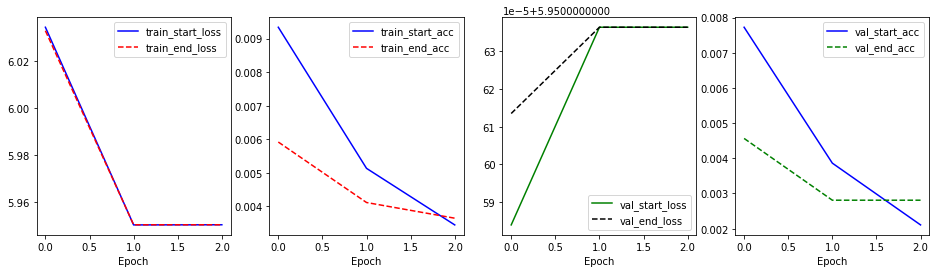

In [115]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(history['train_start_loss'], 'b-', label='train_start_loss')
plt.plot(history['train_end_loss'], 'r--', label='train_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history['train_start_acc'], 'b-', label='train_start_acc')
plt.plot(history['train_end_acc'], 'r--', label='train_end_acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history['val_start_loss'], 'g-', label='val_start_loss')
plt.plot(history['val_end_loss'], 'k--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history['val_start_acc'], 'b-', label='val_start_acc')
plt.plot(history['val_end_acc'], 'g--', label='val_end_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [116]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print()
            print("지문 : ", context)
            print()
            print("정답 : ", answer)
            print()
            print("예측 : ", answer_predict, "\n")
            print("-----------------------------------------------------------------------")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?

지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.

정답 :  1989년 2월 15일

예측 :  배 된 날은?[SEP] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 

-----------------------------------------------------------------------
6
질문 :  임종석이 1989년 2월 15일에 지명수배 받은 혐의는 어떤 시위를 주도했다는 것인가?

지문 :  1989년 2월 15일 

62
질문 :  유사지질학자들이 노아의 홍수를 증명하기 위해 성경 이외에 근거라고 주장한 것들은?

지문 :  역사학과 과학의 발달이 더뎠던 고대사회에서는, 성경이 단순한 교리적인 부분 뿐 아니라 역사책으로서의 권위도 높았기에 노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이 남아 있을것이라고 주장하며 노아의 방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 신화를 들어서 이를 근거라고 주장하기도 했다. 그러나 이러한 전통적 근본주의적 시각은 과거에는 상당히 힘을 얻었으나, 역사학과 과학의 발달에 따라 힘을 잃게 되었고, 홍수지질학은 유사과학으로서 남게 되었다. 현대에는 뒤의 실존논란에서 다루는 것처럼 이러한 근본주의적 해석은 비과학적인 해석으로 여기는 것이 일반적이지만, 남침례교로 대표되는 극보수주의계열 기독교에서는 아직도 이것이 받아들여지고 있다.

정답 :  이슬람교 경전이나 길가메쉬 서사시

예측 :  사회에서는, 성경이 단순한 교리적인 부분 뿐 아니라 역사책으로서의 권위도 높았기에 노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이 남아 있을것이라고 주장하며 노아의 방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전

# pretrained model 사용하기

In [88]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model2 = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model2(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model2.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model2.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_110 (Dense)            multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [89]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(3):
    train_epoch(model2, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model2, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model2.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.8490, 2.1710, acc: 0.5325, 0.4751
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.6989, 1.8998, acc: 0.5532, 0.5281
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8125, 2.1058, acc: 0.5700, 0.5226
save best model


NameError: name 'history' is not defined

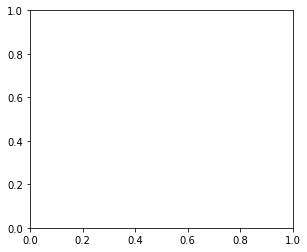

In [91]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(history['train_start_loss'], 'b-', label='train_start_loss')
plt.plot(history['train_end_loss'], 'r--', label='train_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history['train_start_acc'], 'b-', label='train_start_acc')
plt.plot(history['train_end_acc'], 'r--', label='train_end_acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history['val_start_loss'], 'g-', label='val_start_loss')
plt.plot(history['val_end_loss'], 'k--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(history['val_start_acc'], 'b-', label='val_start_acc')
plt.plot(history['val_end_acc'], 'g--', label='val_end_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [90]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model2, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print()
            print("지문 : ", context)
            print()
            print("정답 : ", answer)
            print()
            print("예측 : ", answer_predict, "\n")
            print("-----------------------------------------------------------------------")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?

지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.

정답 :  1989년 2월 15일

예측 :  1989년 2월 15일 

-----------------------------------------------------------------------
1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?

지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했

30
질문 :  헤이그가 군에서 퇴역한 년도는 몇년도입니까?

지문 :  헤이그는 닉슨 대통령이 그를 사성 장군과 육군 부참모로 진급시킬 때 집중 광선과 논쟁으로 들어갔다. 헤이그를 군사의 최상으로 밀어넣은 닉슨의 행동은 대통령의 남자들을 다양한 연방 대리법에서 권한의 직우들로 놓은 노력과 함께 일치였다. 하지만 그는 곧 백악관으로 돌아가 1973년부터 1974년까지 대통령 특별 보좌관을 지냈다. 워터게이트 사건이 일어난지 한달 후, 헤이그는 포위된 닉슨 대통령을 위한 치명적 역할을 하였다. 그일은 8월 닉슨의 사임과 제럴드 포드의 대통령으로 계승으로 이끈 협상들에서 헤이그가 수단이었던 우연이 아니었다. 곧 후에 헤이그는 미국 유럽 연합군 최고사령부의 최고 사령관으로 임명되었다. 그는 나토에서 다음 5년을 보내고 1979년 군에서 퇴역하여 미국 기술 주식 회사의 우두머리가 되었다.

정답 :  1979년

예측 :  5년을 보내고 1979년 

-----------------------------------------------------------------------
32
질문 :  헤이그가 군대에서 퇴역한 년도는?

지문 :  헤이그는 닉슨 대통령이 그를 사성 장군과 육군 부참모로 진급시킬 때 집중 광선과 논쟁으로 들어갔다. 헤이그를 군사의 최상으로 밀어넣은 닉슨의 행동은 대통령의 남자들을 다양한 연방 대리법에서 권한의 직우들로 놓은 노력과 함께 일치였다. 하지만 그는 곧 백악관으로 돌아가 1973년부터 1974년까지 대통령 특별 보좌관을 지냈다. 워터게이트 사건이 일어난지 한달 후, 헤이그는 포위된 닉슨 대통령을 위한 치명적 역할을 하였다. 그일은 8월 닉슨의 사임과 제럴드 포드의 대통령으로 계승으로 이끈 협상들에서 헤이그가 수단이었던 우연이 아니었다. 곧 후에 헤이그는 미국 유럽 연합군 최고사령부의 최고 사령관으로 임명되었다. 그는 나토에서 다음 5년을 보내고 1979년 군에서 퇴역하여 미국 기술 주식 회사의 우두머리가 되었다.

정답 :  1979년

71
질문 :  현재의 생물다양성은 대략 몇 종 인가?

지문 :  기독교 성경 내용에는 모든 종들을 방주에 태운다고 이야기하고 있으나, 어류나 수중 생물에 대해서는 언급하지 않았다. 이것을 신학적 의미로만 받아들이면 괜찮은 문제이나, 이 현상이 실제로 일어났다고 가정할 경우,이는 종 간 생존 환경의 차이에 대해서 간과하고 있다. 수중 생물이라 하더라도 종에 따라 생존할 수 있는 환경은 각각 다른 것이며, 40일 이내에 현존하는 가장 높은 산인 에베레스트 산도 잠기게 할 정도의 폭우로 인해 담수와 염수가 급작스럽게 섞일 경우, 급격한 삼투압 변화로 인해 대부분의 수생생물들이 폐사하게 되며, 결과적으로 육지 뿐 아니라 바다와 강의 모든 생태계가 파괴된다. 이후 5천년이라는 지극히 짧은 세월 동안 지구상의 동식물이 모두 페름기 대멸종 또는 K-T 대멸종에 준하는 대량절멸에 가까운 상태에서부터 시작하여 현재의 대략 870만(±120만)종에 달하는 생물다양성을 획득하려면 모든 생물들이 각 세대마다 종분화가 일어나야 할 만큼 엄청난 속도로 진화 및 번식이 (멸종 없이) 이루어져야만 가능한 일이다. (이와 관련하여 창조과학회 측에서는 북극곰의 예시를 통해 가지고 있던 특성이 없어지는 것이 진화가 아니라고 주장하지만, 통상적으로 알려진 바와 같이 생물학에서는 이미 존재하는 특성이 없어지는 현상, 즉 퇴화 역시 진화의 정의에 포함된다.) 즉, 노아의 홍수가 실재하는 사건이었다면 진화적 종분화가 현재까지 알려진 것과 비교할 수 없이 엄청난 속도로 이루어져야만 현재 지구의 생물다양성을 설명할 수 있다. 게다가 이것은 현재의 생물종 멸종 속도를 전혀 고려하지 않았다. 다시 말해, 노아의 홍수가 실재하는 전지구적인 사건이기 위해서는 최소 캄브리아기 대폭발 수준의 폭발적인 진화적 종분화가 1-2억년이 아니라 최대 3-4천년 이내에 이루어졌어야만 현생 지구의 생물다양성에 대한 설명이 가능해진다. 그보다 더 중요한 것은, 각 동물들이 차지하는 영역과 먹이사슬에서의 위치, 375일 동안 

94
질문 :  반류마루가 미야코 만 해전에서 폭풍우를 만나 대기하고 있던 항구의 이름은 무엇인가?

지문 :  일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어간 순간에 순풍이 불기 시작하여 추격을 뿌리치고 하코다테로 돌아올 수 있었다.

정답 :  하치노헤

예측 :  하치노헤 항 

-----------------------------------------------------------------------
99
질문 :  미야코 만 해전에서 아쓰오카 바키치 함장이 폭풍우를 만난 년도는?

지문 :  일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어